This notebook steps through the creation of the graph to use for comparing accessibility between the generated and actual bus stops.

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import route_planning.helpers.route_planning_helper as rp_helper
import testing.helpers.testing_helper as test_helper
import config

Get a graph of Donegal that has all roads, walkways etc

In [2]:
G_all_donegal = ox.graph_from_place("Donegal, Ireland", network_type="all")
ox.save_graphml(G_all_donegal, filepath=f"{config.testing_graphml_path}/testing_graph.graphml")


#G_all_donegal = ox.load_graphml(filepath=f"{config.testing_graphml_path}/testing_graph.graphml")

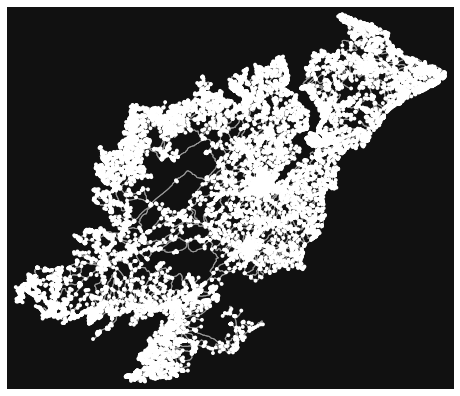

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(G_all_donegal)

Load the graph with labelled bus stops

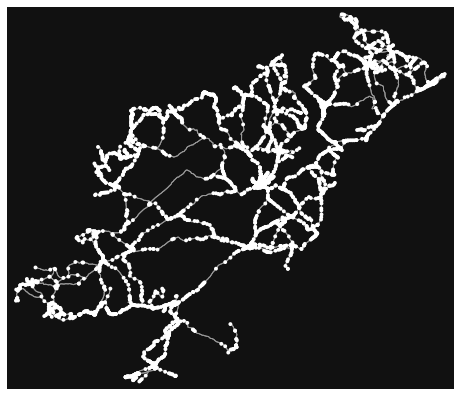

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
G_with_routes = ox.load_graphml(filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")
ox.plot_graph(G_with_routes)

Merge routes data into the testing graph

Convert test graph to nodes/edges dataframes

In [5]:
test_nodes, test_edges = ox.graph_to_gdfs(G_all_donegal)
len(test_nodes)

24857

And the same for the original graph

In [6]:
route_nodes, route_edges = ox.graph_to_gdfs(G_with_routes)

bool_replace = {"True": True, "False": False}
route_nodes["community_route"] = route_nodes["community_route"].map(bool_replace).fillna(False)
route_nodes["actual_stop"] = route_nodes["actual_stop"].map(bool_replace).fillna(False)
route_nodes["connection_route"] = route_nodes["connection_route"].map(bool_replace).fillna(False)

len(route_nodes)

3579

In [7]:
actual_stop_nodes = route_nodes[route_nodes["actual_stop"]]["osmid"].tolist()
len(actual_stop_nodes)

122

Join the route graph nodes with the test graph nodes

In [8]:
merged_nodes = gpd.sjoin(test_nodes, route_nodes,
                         how="left", op="intersects")
len(merged_nodes)

24857

In [9]:
merged_nodes.head()

,y_left,x_left,osmid_left,highway_left,geometry,index_right,y_right,x_right,osmid_right,community,...,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order,highway_right
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),7.806648e+08,54.972684,-7.709056,7.806648e+08,10,...,0,0,False,-1,False,False,NaN,NaN,NaN,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1.417675e+09,55.225775,-7.085802,1.417675e+09,1,...,0,0,False,101,False,False,c,c-99,NaN,NaN


Remove duplicate columns introduced in merge, these are all default values

In [10]:
merged_nodes = merged_nodes.loc[:,~merged_nodes.columns.str.endswith("_right")]
merged_nodes.head()

,y_left,x_left,osmid_left,highway_left,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,False,False,NaN,NaN,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,False,False,c,c-99,NaN


Remove "_left" from remaining column names

In [11]:
merged_nodes.columns = [col.replace("_left", "") for col in merged_nodes.columns]
merged_nodes.head()

,y,x,osmid,highway,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,False,False,NaN,NaN,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,False,False,c,c-99,NaN


Check that all "actual" stops are present

In [12]:
merged_actual_stop_nodes = merged_nodes[merged_nodes["actual_stop"] == True]["osmid"].tolist()
len(merged_actual_stop_nodes)

119

119 found, expecting 122. Find the 3 missing nodes:

In [13]:
diff = set(actual_stop_nodes).difference(merged_actual_stop_nodes)
diff

{258453072, 320673554, 2411894191}

In [14]:
merged_nodes.loc[merged_nodes["osmid"].isin(diff)]

,y,x,osmid,highway,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order
320673554,54.932912,-7.596713,320673554,NaN,POINT (-7.59671 54.93291),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258453072,55.334708,-7.286484,258453072,NaN,POINT (-7.28648 55.33471),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Only 2 of the osm ids were found in merged nodes, update those

In [15]:
merged_nodes.loc[(merged_nodes["osmid"] == 320673554), "actual_stop"] = True
merged_nodes.loc[(merged_nodes["osmid"] == 258453072), "actual_stop"] = True
len(merged_nodes[merged_nodes["actual_stop"] == True]["osmid"])

121

Find the coordinates of the missing node

In [16]:
osm_id = 2411894191
missing_node = route_nodes[route_nodes["osmid"] == osm_id]
missing_node

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection_route,actual_stop,connection,connection_order,actual_route_order,highway
2411894191,55.275666,-7.634499,2411894191,3,0.0002717167601549818,POINT (-7.63450 55.27567),0,0,False,-1,False,True,NaN,NaN,LL7-6,turning_circle


Use those coordinates to find the closest node in graph with all roads included

In [17]:
n = ox.get_nearest_node(G_all_donegal, (missing_node["y"].values[0],
                                        missing_node["x"].values[0]))
n

2385350205

In [18]:
test_edges[test_edges["v"] == n]

,osmid,ref,highway,oneway,length,geometry,name,bridge,lanes,maxspeed,access,width,service,junction,tunnel,area,u,v,key
3307,"[36821991, 230001445, 232879767]",R247,"[secondary, service]",False,818.058,"LINESTRING (-7.63860 55.27311, -7.63858 55.273...",NaN,NaN,NaN,80,permissive,NaN,NaN,NaN,NaN,NaN,6268784624,2385350205,0


Update that node and there should now be 122 actual stop nodes

In [19]:
merged_nodes.loc[(merged_nodes["osmid"] == n), "actual_stop"] = True
len(merged_nodes[merged_nodes["actual_stop"] == True]["osmid"])

122

Check that all generated stops were added

First the connection stops:

In [20]:
connection_present = merged_nodes[merged_nodes["connection_route"] == True]
len(connection_present)

156

2 missing, expecting 158. Now check for community route nodes:

In [21]:
len(merged_nodes[merged_nodes["community_route"] == True])

522

Expecting 539, so there are 16 missing. Compare with original graph's nodes:

In [22]:
community_route_nodes = route_nodes[route_nodes["community_route"]]["osmid"].tolist()
len(community_route_nodes)

539

In [23]:
merged_community_route_nodes = merged_nodes[merged_nodes["community_route"] == True]["osmid"].tolist()
len(merged_community_route_nodes)

522

In [24]:
diff = set(community_route_nodes).difference(merged_community_route_nodes)
diff

{258438551,
 258466029,
 320660381,
 320673554,
 821215522,
 821222613,
 821234197,
 1417678805,
 1417678858,
 1435314101,
 1435314108,
 1522464382,
 1556355680,
 1641061531,
 2111294750,
 2397804385,
 2907774312}

Update the nodes found above

In [25]:
for d in diff:
    merged_nodes.loc[(merged_nodes["osmid"] == d), "community_route"] = True
len(merged_nodes[merged_nodes["community_route"] == True]["osmid"])

539

Now we have the correct number of community stops. Find the missing connecting stops:

In [26]:
len(route_nodes[route_nodes["connection_route"] == True])

158

In [27]:
len(connection_present)

156

In [28]:
# find the 2 missing connection stops
# get nodes from dataframes
original_connecting_nodes = route_nodes[route_nodes["connection_route"] == True]
merged_connecting_nodes = merged_nodes[merged_nodes["connection_route"] == True]


# get a list of osm ids for each set of nodes
original_ids = original_connecting_nodes["osmid"].tolist()
merged_ids = merged_connecting_nodes["osmid"].tolist()

In [29]:
# get the difference
diff = set(original_ids).difference(merged_ids)
diff

{1561807693, 2062405413}

Update the 2 different nodes to have connection_route=True

In [30]:
for d in diff:
    merged_nodes.loc[(merged_nodes["osmid"] == d), "connection_route"] = True
len(merged_nodes[merged_nodes["connection_route"] == True])


158

Now the expected 158 labelled nodes are present, and 650 generated stops in total:

In [31]:
len(merged_nodes[(merged_nodes["community_route"] == True) |
                        (merged_nodes["connection_route"] == True)])

650

In [32]:
# recreate test graph with route data included
G = ox.graph_from_gdfs(merged_nodes, test_edges)
len(G.nodes)

24857

In [33]:
ox.save_graphml(G, filepath=f"{config.testing_graphml_path}/merged_routes.graphml")

Visualise the real and generated bus stop locations

<GeoAxesSubplot:>

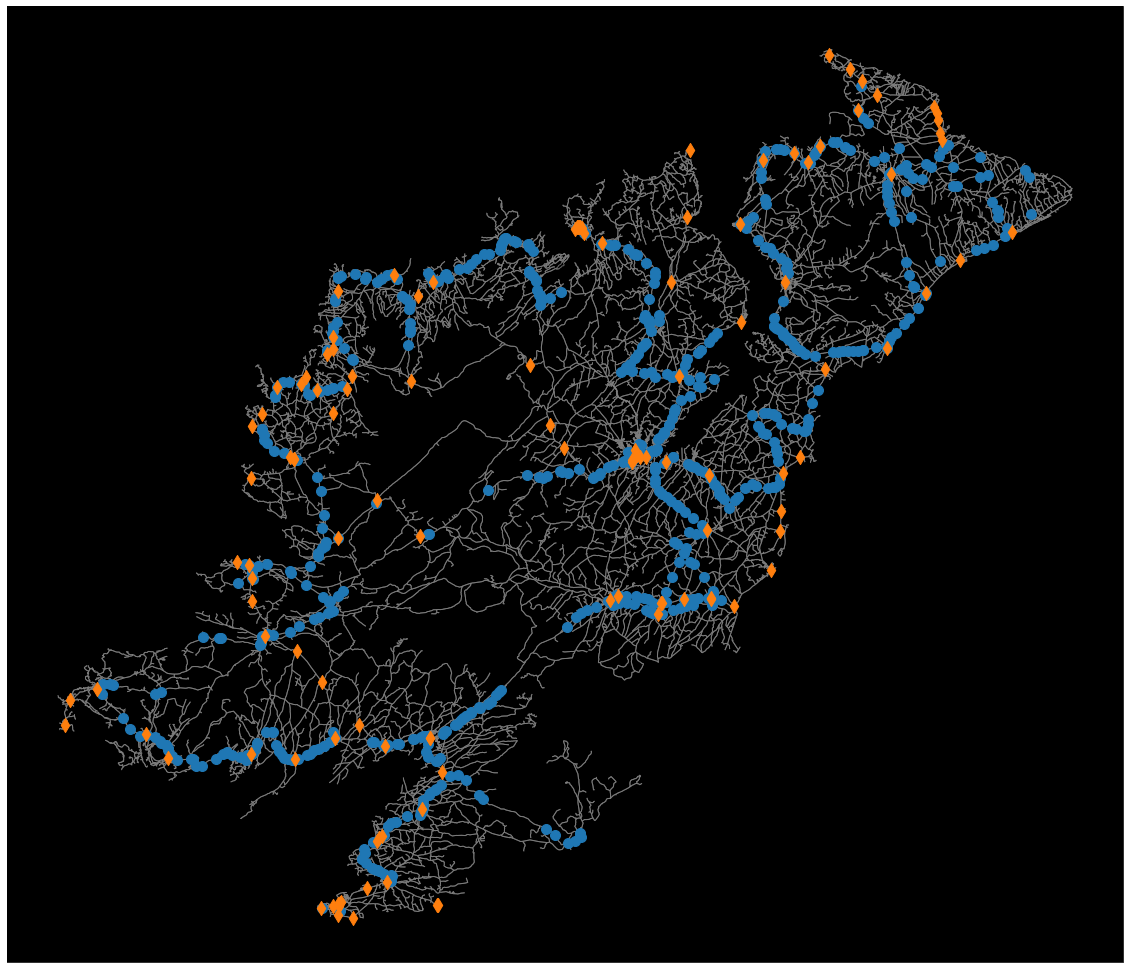

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

nodes, edges = ox.graph_to_gdfs(G)
gen_route_nodes = nodes[(nodes["community_route"] == True) |
                        (merged_nodes["connection_route"] == True)]
actual_route_nodes = nodes[(nodes["actual_stop"] == True)]


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_route_nodes.plot(
    ax=ax,
    marker="o",
    markersize=100,
    zorder=2,
    categorical=True
)

actual_route_nodes.plot(
    ax=ax,
    marker="d",
    markersize=100,
    zorder=2,
    categorical=True
)